# Running Armory Scenarios Interactively

In this tutorial, we'll demonstrate how to run Armory scenarios interactively, export and visualize data examples, and more. We'll use the CARLA object detection scenario as an example, although what follows is instructive for using Armory in general.

To run Armory scenarios interactively, be sure to pass the `--interactive` or `--jupyter` flag when invoking `armory run <CONFIG>`. After doing so, you will receive instructions logged to console on how to attach to the newly launched Docker container. If using the `--jupyter` flag, you'll also receive a URL to open the Jupyter notebook.

To follow along with this tutorial, run the following command: `armory run scenario_configs/carla_obj_det_adversarialpatch_undefended.json --jupyter`

### Loading the Scenario
To load the scenario, we use Armory's `get()` function in `armory.scenarios.main`. The filepath used below is an example, and you'll receive the specific path logged to console after invoking `armory run`.

Calling `load()` will load the pieces (model, dataset, attack, etc.) necessary to run the scenario.

In [2]:
from armory.scenarios.main import get as get_scenario

s = get_scenario("/armory/tmp/2022-05-23T153707.378169/interactive-config.json").load()

2022-05-23 15:38:32 40s INFO     armory.scenarios.main:_scenario_setup:49 armory outputs and logs will be written to /armory/outputs/2022-05-23T153707.378169


/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'codeload.github.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


2022-05-23 15:38:32 40s INFO     armory.utils.external_repo:download_and_extract_repo:129 Downloading external repo: colour-science/colour@v0.3.16
2022-05-23 15:38:33 41s INFO     armory.data.utils:maybe_download_weights_from_s3:47 Using available carla_rgb_weights_eval5.pt in Armory `saved_model_dir`
2022-05-23 15:38:36 44s INFO     matplotlib.font_manager:_load_fontmanager:1443 generated new fontManager
2022-05-23 15:38:36 44s INFO     armory.scenarios.scenario:load_dataset:204 Loading test dataset carla_obj_det_dev...


Now that we've instatiated the scenario object, we could simply call `s.evaluate()` to run the entire scenario from start to finish. However, in this tutorial, we'll demonstrate how to run the scenario in a step-by-step fashion.

To grab our first batch of data, we call the scenario's `next()` method. At this point, we can now access `x` and `y` as attributes of the scenario object, as well as `i` for the batch index:

In [3]:
s.next()
s.x.shape

(1, 960, 1280, 3)

### Executing the Scenario
Armory scenarios, at a high level, execute in the following manner:
1. Load the next batch of data
2. Predict on the benign sample
3. Generate an adversarial sample and make a prediction on it

We did step 1 when we called `s.next()` earlier. To predict on the benign sample, we can call `s.run_benign()`. Similarly for step 3, we call `s.run_attack()`. Calling `s.evaluate_current()` would call both of these methods, but in this example we'll run each step one at a time:

In [4]:
s.run_benign()

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The benign prediction is now accessible via the `y_pred` attribute:

In [5]:
s.y_pred

[{'boxes': array([[  0.00000000e+00,   4.31345276e+02,   5.26877808e+02,
            6.33994141e+02],
         [  1.19789160e+03,   4.61878448e+02,   1.23797986e+03,
            5.52101562e+02],
         [  1.04172998e+03,   4.59246704e+02,   1.06950269e+03,
            5.36661743e+02],
         [  8.22440369e+02,   4.68223999e+02,   8.46305420e+02,
            5.20457336e+02],
         [  9.14201355e+02,   4.62828400e+02,   9.54305725e+02,
            5.26226624e+02],
         [  7.71409302e+02,   4.68521088e+02,   7.86138733e+02,
            5.10685150e+02],
         [  7.85914246e+02,   4.70420380e+02,   8.04799866e+02,
            5.23021118e+02],
         [  7.77562683e+02,   4.67268280e+02,   7.96583557e+02,
            5.21993408e+02],
         [  8.92775146e+02,   4.70374176e+02,   9.20738892e+02,
            4.93356903e+02],
         [  3.29152130e+02,   4.81392303e+02,   5.22157898e+02,
            5.81324768e+02],
         [  1.26745471e+03,   4.85850464e+02,   1.28000000e+0

Next, we run the attack. For the sake of brevity in this tutorial, we'll modify the `"max_iter"` parameter of the attack first:

In [6]:
s.config["attack"]["kwargs"]["max_iter"] = 5
s.load_attack()

s.run_attack()

RobustDPatch iteration:   0%|          | 0/5 [00:00<?, ?it/s]

At this point, we can access the adversarial sample via the `x_adv` attribute:

In [7]:
s.x_adv.shape

(1, 960, 1280, 3)

To continue this process, we could keep calling `s.next()` followed by `s.run_benign()` and `s.run_attack()`. Once we'd like to close out the experiment, we could then call `s.finalize_results()` and observe the logged results. Instead, in the following section we'll show how to export and view data examples.

### Exporting and Viewing Data Examples

#### Exporting Data
Here we will show how to export data examples using the `sample_exporter` object. By "export", we mean write examples (.png, .wav, .mp4, etc. depending on the scenario) to the `~/.armory` experiment output directory. 

Each scenario object contains a `sample_exporter` which implements an `export()` method taking the following inputs:

```
def export(self, x, basename, **kwargs):
```

In the simplest case, to export the raw inputs without any annotation (e.g. bounding boxes), we can call the following (note that the `with_boxes` kwarg is specific to object detection scenarios):

In [9]:
batch_number = s.i
s.sample_exporter.export(s.x[0], f"benign_x_batch_{batch_number}", with_boxes=False)

print(s.sample_exporter.output_dir)

/armory/outputs/2022-05-23T153707.378169/saved_samples


The print statement was added to show the location of the Armory scenario output directory. If running in docker, note that this is the path inside the container and that the container path `/armory` should map to the host path `~/.armory`.

Now looking inside the scenario output directory, we see the image we just exported.

```
I have no name!@b24233d4dd79:/workspace$ ls /armory/outputs/2022-05-23T153707.378169/saved_samples
benign_x_batch_0.png

```

This next bit is specific to object detection, but to save the image with ground-truth and predicted boxes we can pass `y` and `y_pred` kwargs to the `export()` call:

In [11]:
s.sample_exporter.export(
    s.x[0],
    f"benign_x_batch_{batch_number}_with_boxes",
    y=s.y[0],
    y_pred=s.y_pred[0],
    with_boxes=True,
)

#### Viewing Data
The `sample_exporter` class also makes it easy to retrieve viewable examples, specifically PIL objects in the case of image-related scenarios. These can be accessed via the `sample_exporter`'s `get_sample()` method which typically takes in a single input `x`. For scenarios with bounding boxes, this method also optionally takes in `y`, `y_pred`, and a boolean `with_boxes`. 

In [12]:
x_pil = s.sample_exporter.get_sample(
    s.x[0], y=s.y[0], y_pred=s.y_pred[0], with_boxes=True
)
x_adv_pil = s.sample_exporter.get_sample(
    s.x_adv[0], y=s.y[0], y_pred=s.y_pred_adv[0], with_boxes=True
)

Now we can use Jupyter's built-in `display()` function to view the images:

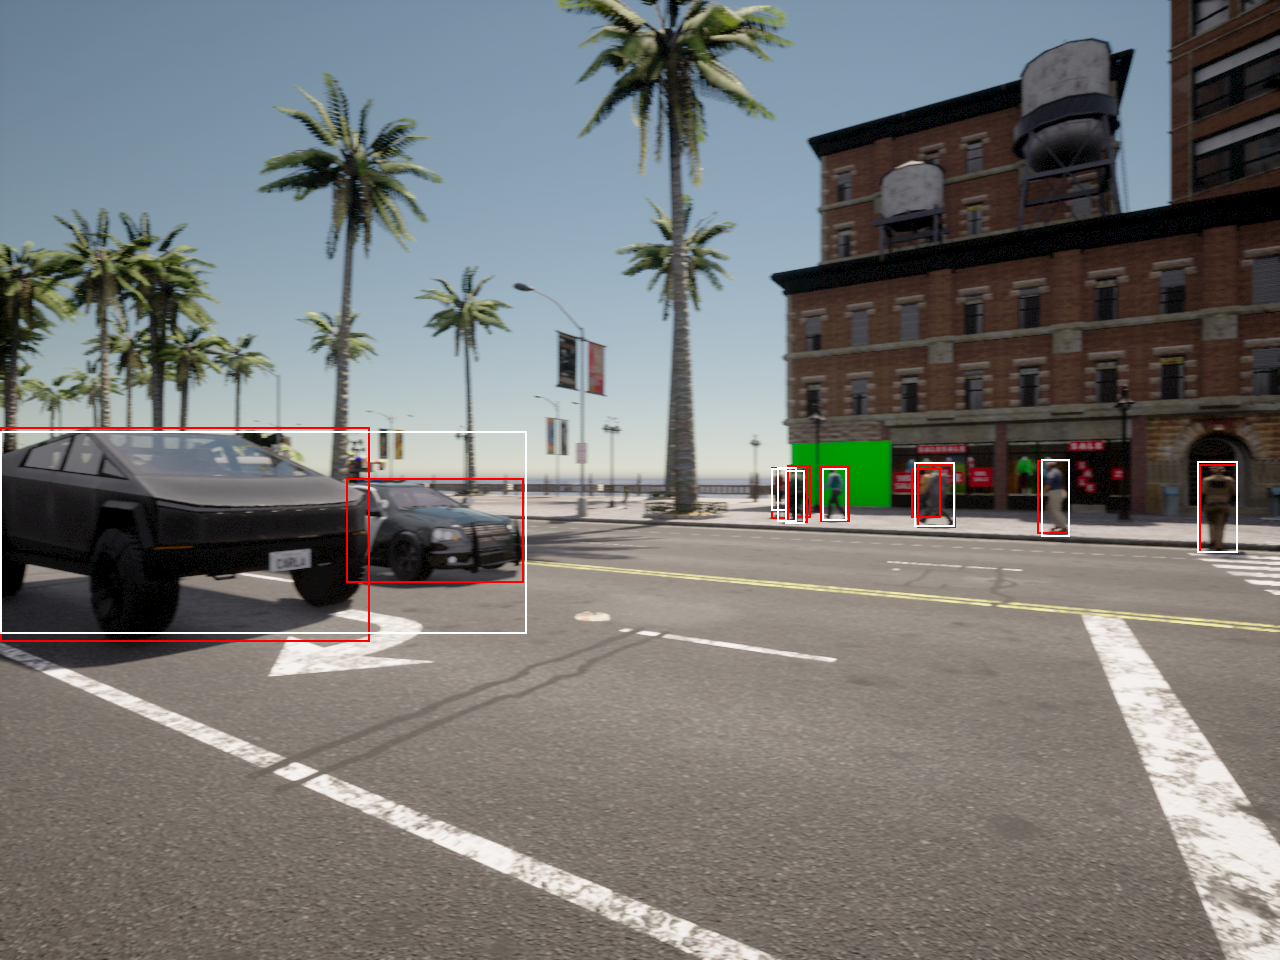

In [13]:
display(x_pil)

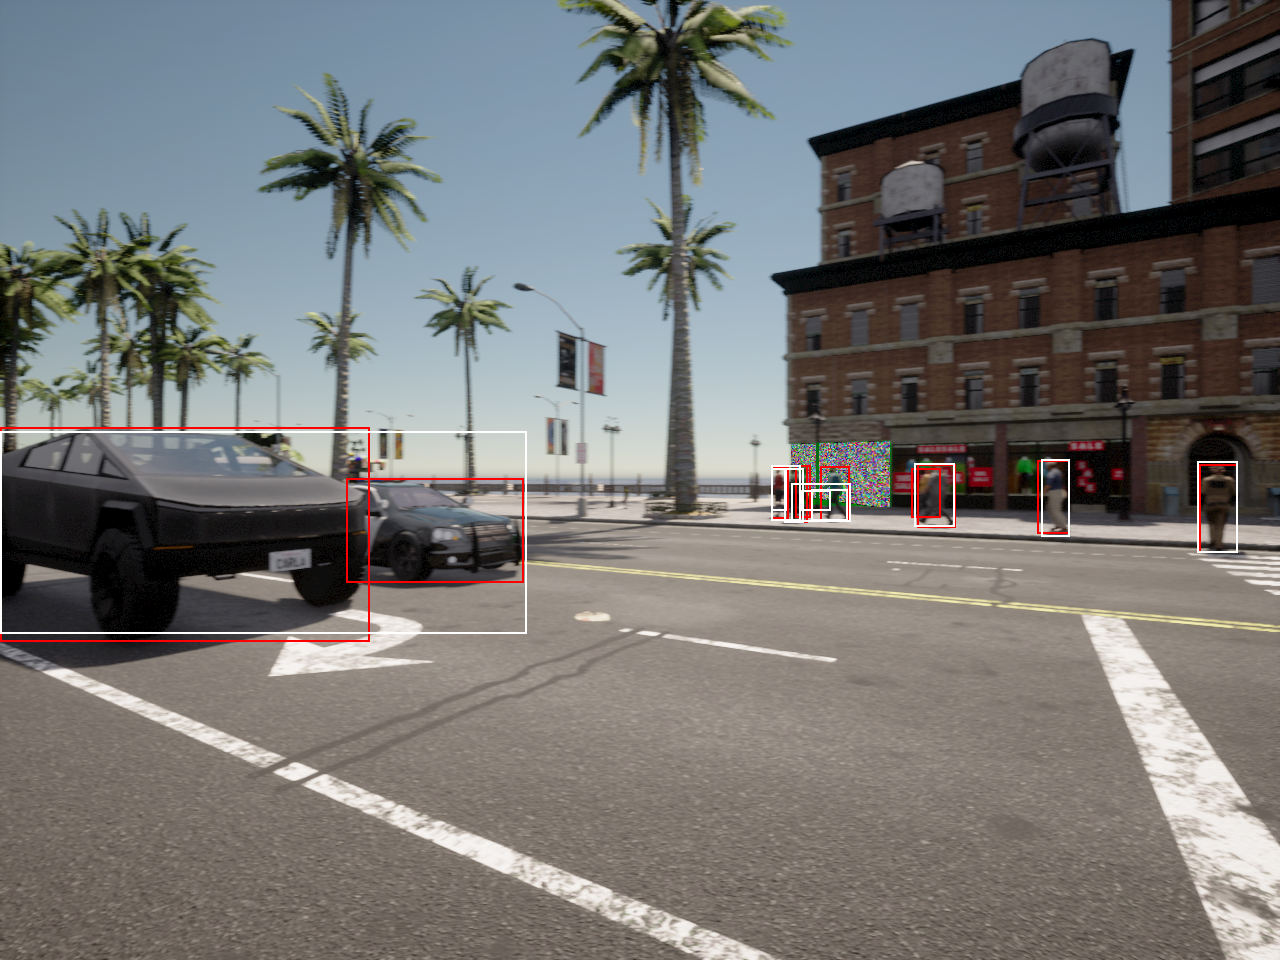

In [14]:
display(x_adv_pil)

### Finishing the Experiment
If you'd like to run the experiment over the rest of the data examples, simply call `s.evaluate()`. Doing so will complete the rest of the evaluation, prepare and finalize the results, and write the results JSON to the Armory scenario output directory.

If instead you'd like to finish the experiment at its current step, call `s.finalize_results()` which logs the experiment results to console.

In [15]:
s.finalize_results()

2022-05-23 16:56:16 1h18m24s SUCCESS  armory.instrument.config:_write:220 benign_carla_od_AP_per_class on benign examples w.r.t. ground truth labels: {'mean': 0.89500000000000002, 'class': {1: 0.93999999999999995, 2: 0.84999999999999998}}
2022-05-23 16:56:16 1h18m24s SUCCESS  armory.instrument.config:_write:220 adversarial_carla_od_AP_per_class on adversarial examples w.r.t. ground truth labels: {'mean': 0.69999999999999996, 'class': {1: 0.69999999999999996, 2: 0.69999999999999996}}
2022-05-23 16:56:16 1h18m24s SUCCESS  armory.instrument.config:_write:220 benign_mean_carla_od_disappearance_rate on benign examples w.r.t. ground truth labels: 30.00%
2022-05-23 16:56:16 1h18m24s SUCCESS  armory.instrument.config:_write:220 adversarial_mean_carla_od_disappearance_rate on adversarial examples w.r.t. ground truth labels: 40.00%
2022-05-23 16:56:16 1h18m24s SUCCESS  armory.instrument.config:_write:220 benign_mean_carla_od_hallucinations_per_image on benign examples w.r.t. ground truth labels:

Afterwards, you can then call `s.save()` to write the results JSON to the Armory output directory. Alternatively, if you'd like to return the results as a Python dictionary, call `s.prepare_results()`.

In [16]:
results_dict = s.prepare_results()
print(results_dict.keys())

dict_keys(['armory_version', 'config', 'results', 'timestamp'])


In [17]:
print(results_dict["results"])

{'benign_carla_od_AP_per_class': [{'mean': 0.89500000000000002, 'class': {1: 0.93999999999999995, 2: 0.84999999999999998}}], 'adversarial_carla_od_AP_per_class': [{'mean': 0.69999999999999996, 'class': {1: 0.69999999999999996, 2: 0.69999999999999996}}], 'benign_mean_carla_od_disappearance_rate': [0.30000000000000004], 'adversarial_mean_carla_od_disappearance_rate': [0.40000000000000002], 'benign_mean_carla_od_hallucinations_per_image': [1.0], 'adversarial_mean_carla_od_hallucinations_per_image': [3.0], 'benign_mean_carla_od_misclassification_rate': [0.0], 'adversarial_mean_carla_od_misclassification_rate': [0.0], 'benign_mean_carla_od_true_positive_rate': [0.69999999999999996], 'adversarial_mean_carla_od_true_positive_rate': [0.59999999999999998], 'perturbation_mean_l0': [14662.0], 'adversarial_carla_od_AP_per_class_wrt_benign_preds': [{'mean': 0.44500000000000001, 'class': {1: 0.53000000000000003, 2: 0.35999999999999999}}], 'adversarial_mean_carla_od_disappearance_rate_wrt_benign_pred

In [18]:
s.save()

2022-05-23 16:57:03 1h19m11s INFO     armory.scenarios.scenario:save:431 Saving evaluation results to path /armory/outputs/2022-05-23T153707.378169/CarlaObjectDetectionTask_1653320313.json inside container.
